In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys; sys.path.append("..")
from src.utils import read_data

from src.optimizer import Adam
from src.autoencoder import Autoencoder
from src.perceptron_multicapa import Layer

data_dict = read_data("../data/font.csv")

# Ejercicio 1-a
Implementar un Autoencoder básico para las imagenes de la lista de caracteres del archivo "font.h".

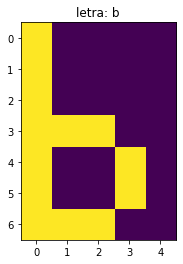

In [6]:
letra = "b"
plt.imshow(data_dict[letra])
plt.title("letra: " + letra)
plt.show()

La arquitectura seleccionada va reduciendo dimensiones de forma progresiva con entradas saturables entre 0 y 1.
Cuando se llega a la capa 3 con 5 neuronas, es posible aprender $2^6$ patrones distintos.
La capa siguiente es lineal o relu para evitar que las salidas queden saturadas y se pierda información. 
Para decodificar la salida se utilizó una arquitectura invertida al codificador.

In [8]:
from src.optimizer import Adam
from src.autoencoder import Autoencoder
from src.perceptron_multicapa import Layer

autoencoder = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

autoencoder.optimizer.learning_rate = 0.005
history = autoencoder.train_autoencoder(X, epochs=2_500, batch_size=1)

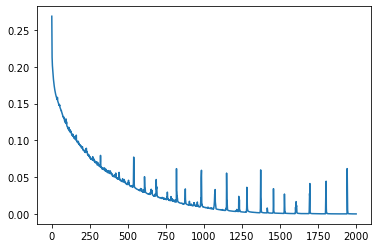

In [9]:
e = [i for i, h in enumerate(history)]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

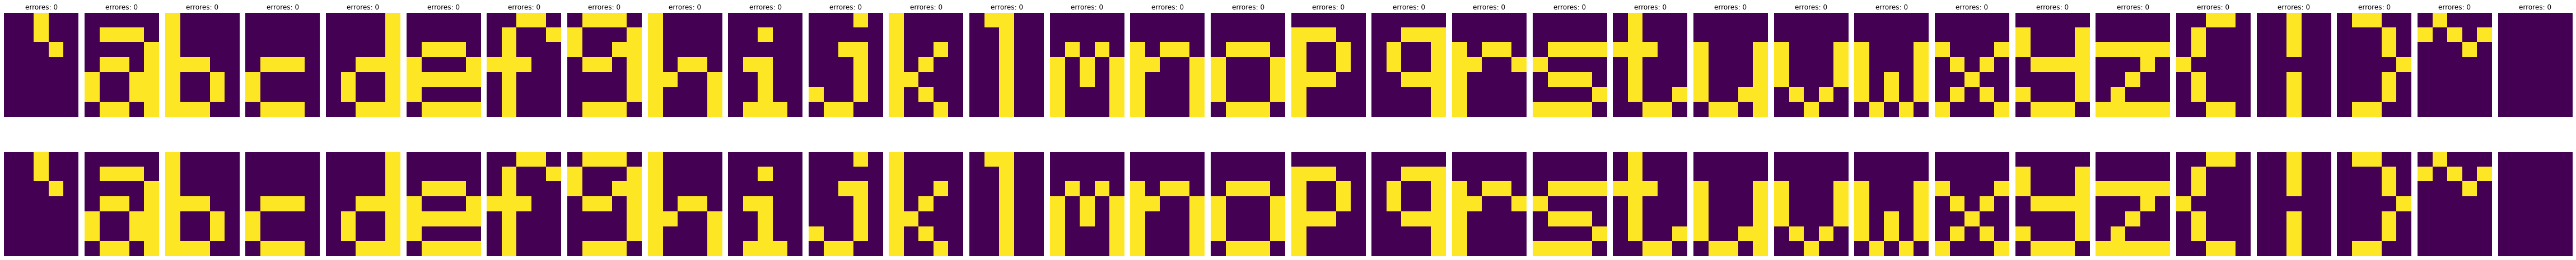

El máximo error alcanzado es 0


In [10]:
indices = 32
fig, ax = plt.subplots(2, indices, figsize=(indices * 2, 8))

max_error = 0
for idx in range(indices):
	threshold = 0.5
	ax[0, idx].imshow(autoencoder.forward(X[idx]).reshape(7, 5) > threshold)
	ax[1, idx].imshow(X[idx].reshape(7, 5))

	ax[0, idx].set_axis_off()
	ax[1, idx].set_axis_off()

	error = sum(abs((autoencoder.forward(X[idx]) > threshold) - X[idx]))
	ax[0, idx].set_title("errores: {}".format(error))
	
	max_error = max(error, max_error)

plt.tight_layout()
plt.show()

print("El máximo error alcanzado es {}".format(max_error))

Se observó que el espacio latente trata de separar lo más posible cada letra.
Sin embargo, hay clusters de grupos de letras similares como:
* b, h
* s, z
* v, u

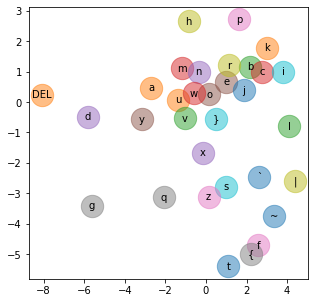

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

Para armar una letra que no esta en el espacio solución podemos tomar varios puntos aleatorios del espacio latente y observar su salida.

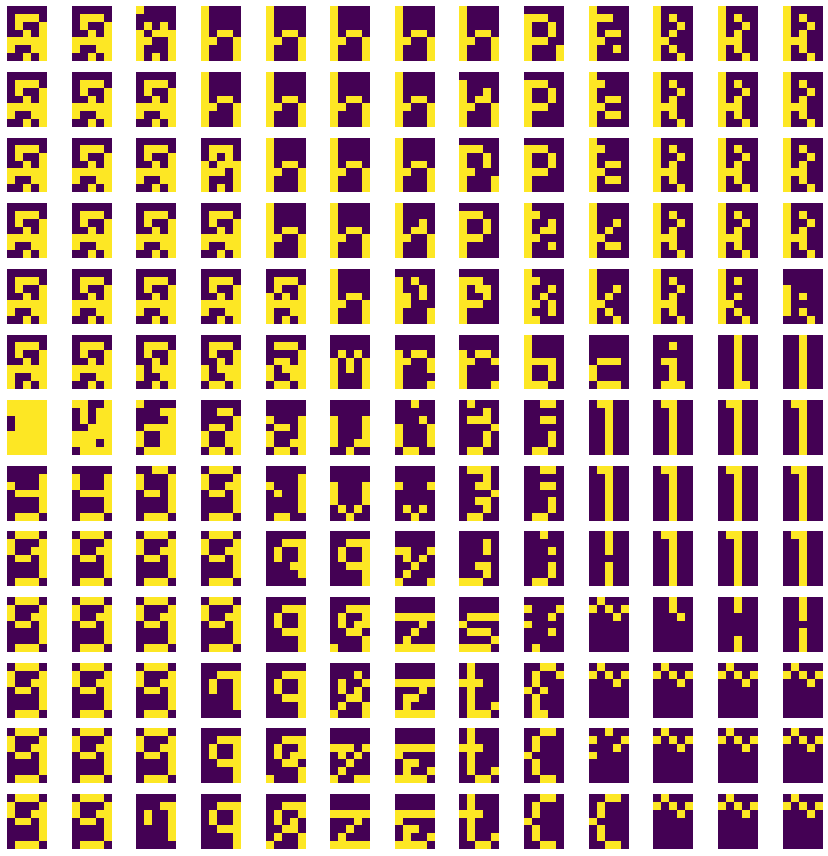

In [12]:
x = np.linspace(-6, 6, 13)
y = np.linspace(-6, 6, 13)

threshold = 0.5

fig, ax = plt.subplots(len(x), len(y), figsize=(12,12))
for i, xi in enumerate(x):
	for j, yj in enumerate(y):
		
		letra = autoencoder.decode([xi, -yj]) > threshold
		ax[j, i].imshow(letra.reshape(7, 5))
		ax[j, i].set_axis_off()

plt.tight_layout()
plt.show()

## Otras arquitecturas consideradas

In [22]:
X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

autoencoder1 = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder2 = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  4, "sigmoid"),
    Layer( 4,  2, "linear"),
    Layer( 2,  4, "sigmoid"),
    Layer( 4, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder3 = Autoencoder([
    Layer(35,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 35, "sigmoid"),
], bottleneck_index=1, loss_fun="bce")

history = []
nombres = ["original", "embudo", "corto"]
autoencoders = [autoencoder1, autoencoder2, autoencoder3]

for autoencoder in autoencoders:
	autoencoder.optimizer.learning_rate = 0.005
	history.append(autoencoder.train_autoencoder(X, epochs=5_000, batch_size=1))


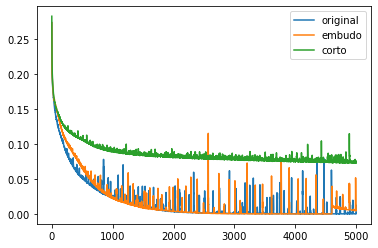

In [23]:
for hist, nombre in zip(history, nombres):
	e = [h["epoch"] for h in hist]
	l = [h["train_loss"] for h in hist]
	plt.plot(e, l, label=nombre)
	
plt.legend()
plt.show()

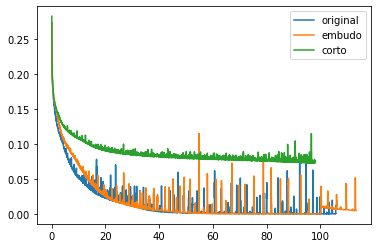

In [24]:
for hist, nombre in zip(history, nombres):
	l = [h["train_loss"] for h in hist]
	e = [h["elapsed_training_time"] for h in hist]
	plt.plot(e, l, label=nombre)
plt.legend()
plt.show()

In [25]:
indices = 32
threshold = 0.5

errores = []
for autoencoder in autoencoders:
	max_error = 0
	for idx in range(indices):
		error = sum(abs((autoencoder.forward(X[idx]) > threshold) - X[idx]))
		max_error = max(error, max_error)
	errores.append(max_error)

for error, name in zip(errores, nombres):
	print("Autoencoder: {}\t Error: {}".format(name, error))

Autoencoder: original	 Error: 8
Autoencoder: embudo	 Error: 5
Autoencoder: corto	 Error: 9


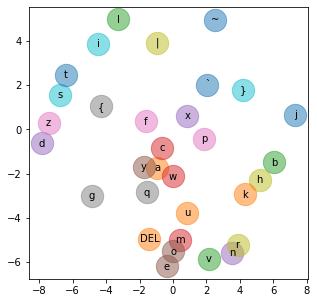

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder1.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

# Ejercicio 1-b
Implementar una variante que implemente un "Denoising Autoencoder".

In [219]:
def add_noise(x, noise_factor):
    x_noisy = x.copy()
    mask = np.random.rand(*x.shape) < noise_factor
    x_noisy[mask] = 1 - x_noisy[mask]  # flip bits
    return x_noisy

In [220]:
X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

noise_level = 0.3

X_out = X
X_noisy = add_noise(X, noise_level)
for _ in range(5):
 	X_out = np.vstack((X_out, X))
 	X_noisy = np.vstack((X_noisy, add_noise(X, noise_level)))


In [221]:
autoencoder = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder.optimizer.learning_rate = 0.005
history = autoencoder.train_autoencoder(X_noisy, X_out, epochs=250, batch_size=1)

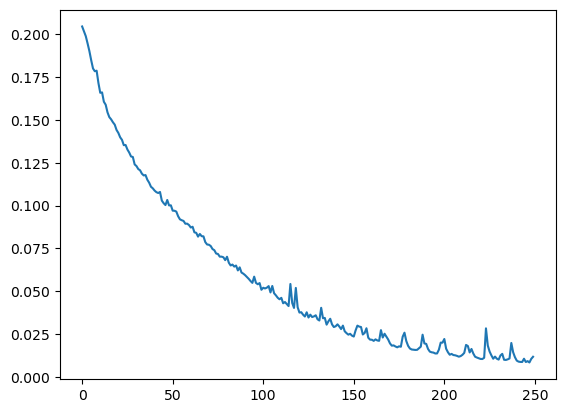

In [222]:
e = [i for i, h in enumerate(history)]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

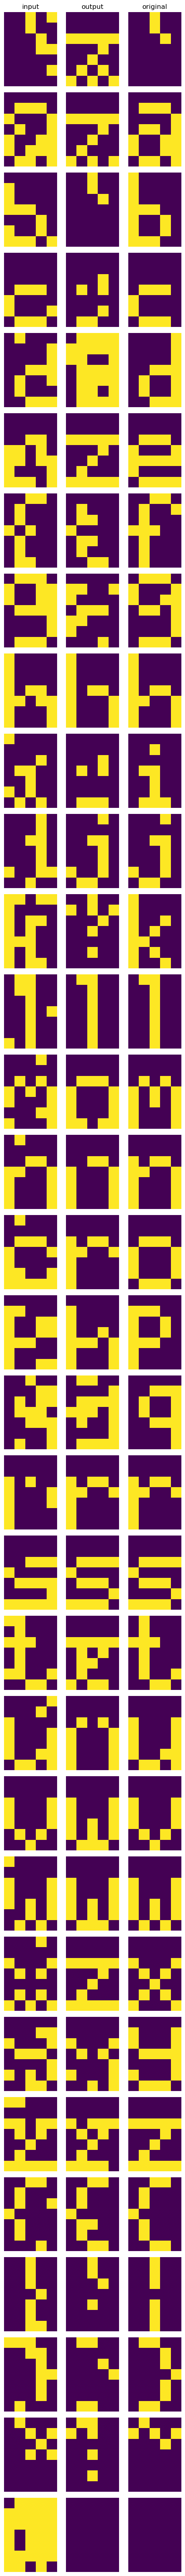

In [223]:
X_noisy = add_noise(X, 0.10)

imagenes = 32
fig, ax = plt.subplots(imagenes, 3, figsize=(5,imagenes*2))

for i in range(imagenes):
	X_out = autoencoder.forward(X_noisy[i])

	ax[i, 0].imshow(X_noisy[i].reshape(7, 5))
	ax[i, 1].imshow(X_out.reshape(7, 5) > 0.5)
	ax[i, 2].imshow(X[i].reshape(7, 5))
	
	ax[i, 0].set_axis_off()
	ax[i, 1].set_axis_off()
	ax[i, 2].set_axis_off()

ax[0, 0].set_title("input")
ax[0, 1].set_title("output")
ax[0, 2].set_title("original")

plt.tight_layout()
plt.show()

## Con espacio latente de dos dimensiones

In [224]:
X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

noise_level = 0.2

X_out = X
X_noisy = add_noise(X, noise_level)
for _ in range(5):
 	X_out = np.vstack((X_out, X))
 	X_noisy = np.vstack((X_noisy, add_noise(X, noise_level)))


In [225]:
autoencoder = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder.optimizer.learning_rate = 0.005
history = autoencoder.train_autoencoder(X_noisy, X_out, epochs=2000, batch_size=1)

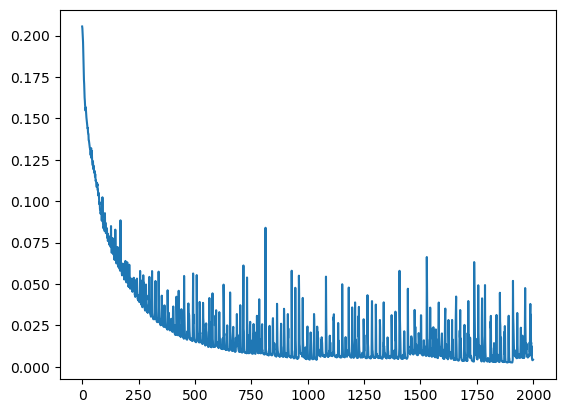

In [226]:
e = [i for i, h in enumerate(history)]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

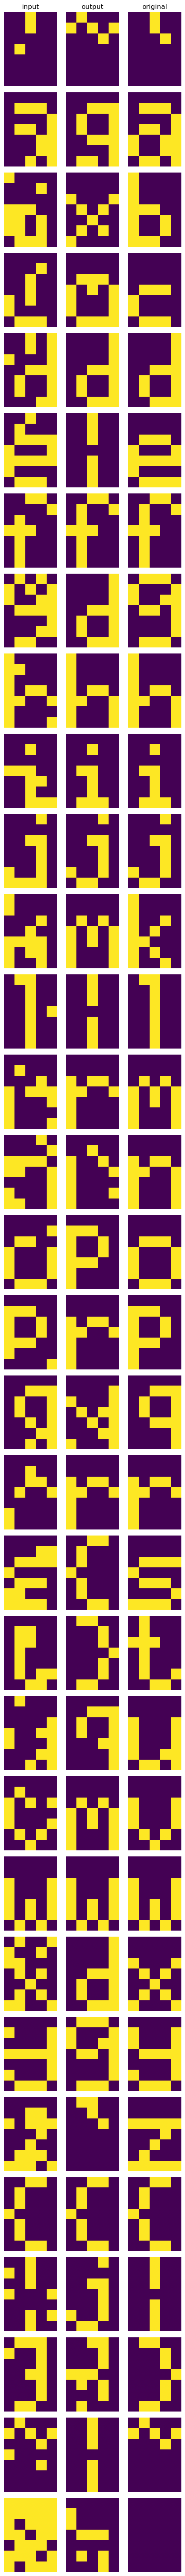

In [227]:
X_noisy = add_noise(X, 0.10)

imagenes = 32
fig, ax = plt.subplots(imagenes, 3, figsize=(5,imagenes*2))

for i in range(imagenes):
	X_out = autoencoder.forward(X_noisy[i])

	ax[i, 0].imshow(X_noisy[i].reshape(7, 5))
	ax[i, 1].imshow(X_out.reshape(7, 5) > 0.5)
	ax[i, 2].imshow(X[i].reshape(7, 5))
	
	ax[i, 0].set_axis_off()
	ax[i, 1].set_axis_off()
	ax[i, 2].set_axis_off()

ax[0, 0].set_title("input")
ax[0, 1].set_title("output")
ax[0, 2].set_title("original")

plt.tight_layout()
plt.show()

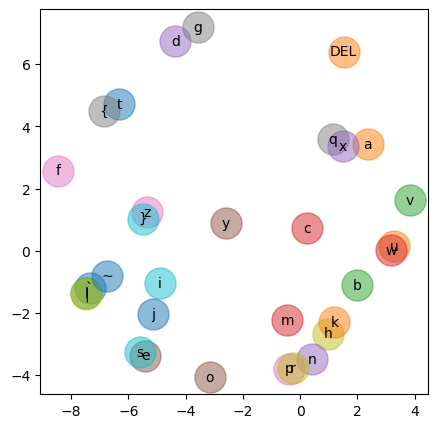

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

## Uso de DropOut

In [229]:
X = np.array(list(data_dict.values()))
X = X.reshape(-1, 5 * 7)

noise_level = 0.3

X_out = X
X_noisy = add_noise(X, noise_level)
for _ in range(5):
 	X_out = np.vstack((X_out, X))
 	X_noisy = np.vstack((X_noisy, add_noise(X, noise_level)))


In [230]:
autoencoder1 = Autoencoder([
    Layer(35, 20, "sigmoid"),
    Layer(20,  6, "sigmoid"),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid"),
    Layer( 6, 20, "sigmoid"),
    Layer(20, 35, "sigmoid"),
], bottleneck_index=2, loss_fun="bce")

autoencoder1.optimizer.learning_rate = 0.01
history1 = autoencoder1.train_autoencoder(X_noisy, X_out, epochs=300, batch_size=5)

In [231]:
autoencoder2 = Autoencoder([
    Layer(35, 20, "sigmoid", dropout_rate=0.15),
    Layer(20,  6, "sigmoid", dropout_rate=0.15),
    Layer( 6,  2, "linear"),
    Layer( 2,  6, "sigmoid", dropout_rate=0.00),
    Layer( 6, 20, "sigmoid", dropout_rate=0.00),
    Layer(20, 35, "sigmoid", dropout_rate=0.00),
], bottleneck_index=2, loss_fun="bce")

autoencoder2.optimizer.learning_rate = 0.01
history2 = autoencoder2.train_autoencoder(X_noisy, X_out, epochs=300, batch_size=5)

for layer in autoencoder2.layers:
	layer.dropout_rate=0.0

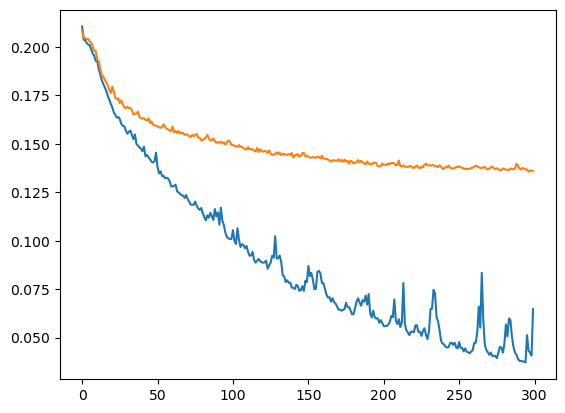

In [232]:
e = [h["epoch"] for h in history1]
l = [h["train_loss"] for h in history1]
plt.plot(e, l)

e = [h["epoch"] for h in history2]
l = [h["train_loss"] for h in history2]
plt.plot(e, l)

plt.show()

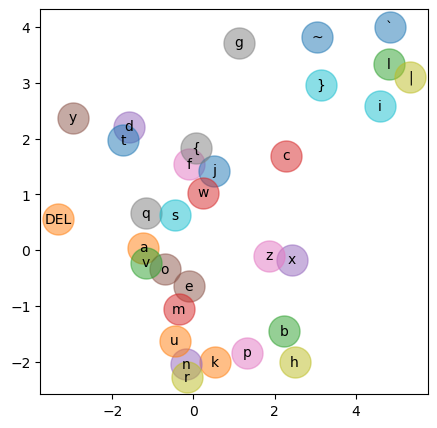

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder1.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

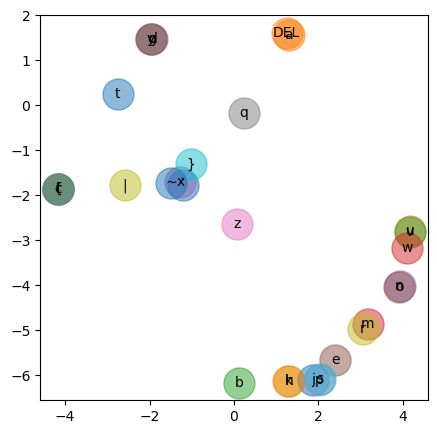

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for letra in data_dict.keys():
	arr = data_dict[letra]
	x, y = autoencoder2.encode(arr.reshape(-1))
	plt.scatter(x, y, label=letra, s=500, alpha=0.5, data=letra)
	plt.text(x, y, letra, ha="center", va="center", fontsize=10)
plt.show()

Errores: 547
Errores: 542


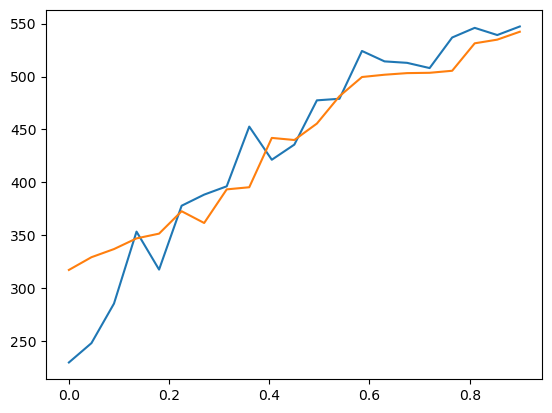

In [235]:
errores1 = []
errores2 = []

noise_levels = np.linspace(0, 0.9, 21)

for noise in noise_levels:
	X_noisy = add_noise(X, noise)
	error1 = 0
	error2 = 0

	for i in range(len(X)):
		X_out_1 = autoencoder1.forward(X_noisy[i])
		X_out_2 = autoencoder2.forward(X_noisy[i])
		error1 += sum(np.abs(X[i] - X_out_1))
		error2 += sum(np.abs(X[i] - X_out_2))

	errores1.append(error1)
	errores2.append(error2)

plt.plot(noise_levels, errores1)
plt.plot(noise_levels, errores2)

print("Errores: {:.0f}".format(error1))
print("Errores: {:.0f}".format(error2))